In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def one_tree_gc(X, y, depth=3):
    dt = DecisionTreeClassifier()
    
    params = {'criterion': ['gini', 'entropy'],
         'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
         'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    
    cv = TimeSeriesSplit(n_splits=8)
    gs = GridSearchCV(dt, params, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    gs.fit(X, y)
    
    score = gs.best_score_
    dt = gs.best_estimator_
    dt.fit(X, y)
    print(dt)
    print(X.columns[np.argsort(dt.feature_importances_)])
    dot_data = StringIO()
    export_graphviz(dt, out_file=dot_data, max_depth=depth, feature_names=X.columns,
    filled=True, rounded=True,
    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    img = Image(graph.create_png())
    return score, img
    
    

In [4]:
# train_mine = pd.read_csv('ready_orders1.csv',error_bad_lines=False,parse_dates=[0])
# train_mine = pd.read_csv('ready_orders_only_-10.csv',error_bad_lines=False,parse_dates=[0])
train_mine = pd.read_csv('read_orders_include_short.csv',error_bad_lines=False,parse_dates=[0])
#read_orders_include_short поставить после for_shkolota
train_mine = train_mine[train_mine['country'] == 'ru']
train_mine = train_mine.dropna()
train_mine['basic_typ'] = np.where(train_mine['basic_typ'] == 0, 0, 1)
train_mine['ege_typ'] = np.where(train_mine['ege_typ'] == 0, 0, 1)
train_mine['olimp_typ'] = np.where(train_mine['olimp_typ'] == 0, 0, 1)
train_mine['lang_typ'] = np.where(train_mine['lang_typ'] == 0, 0, 1)
train_mine['word_ex_typ'] = np.where(train_mine['word_ex_typ'] == 0, 0, 1)
train_mine['music_typ'] = np.where(train_mine['music_typ'] == 0, 0, 1)
train_mine['logoped_typ'] = np.where(train_mine['logoped_typ'] == 0, 0, 1)
train_mine = train_mine.drop(columns=['country', 'order_id', 'sz'])

In [5]:
train_mine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474983 entries, 0 to 3042265
Data columns (total 22 columns):
receivd        object
city           float64
mesto          int64
prodolzh       int64
stoim          int64
wgender        int64
obraz          int64
opyt           int64
aimi           int64
uvozr          int64
ulevel         int64
target         int64
class          int64
retake         int64
aim_ege_typ    int64
basic_typ      int64
ege_typ        int64
olimp_typ      int64
lang_typ       int64
word_ex_typ    int64
music_typ      int64
logoped_typ    int64
dtypes: float64(1), int64(20), object(1)
memory usage: 434.3+ MB


In [6]:
train_mine['lang_typ'].value_counts()

0    1771573
1     703410
Name: lang_typ, dtype: int64

In [7]:
data = train_mine
data['receivd'] = pd.to_datetime(data['receivd'])
data.sort_values(['receivd'], inplace=True)

In [8]:
data.reset_index(inplace=True, drop=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2474983 entries, 0 to 2474982
Data columns (total 22 columns):
receivd        datetime64[ns]
city           float64
mesto          int64
prodolzh       int64
stoim          int64
wgender        int64
obraz          int64
opyt           int64
aimi           int64
uvozr          int64
ulevel         int64
target         int64
class          int64
retake         int64
aim_ege_typ    int64
basic_typ      int64
ege_typ        int64
olimp_typ      int64
lang_typ       int64
word_ex_typ    int64
music_typ      int64
logoped_typ    int64
dtypes: datetime64[ns](1), float64(1), int64(20)
memory usage: 415.4 MB


In [10]:
data['month'] = data['receivd'].map(lambda x: x.month)
data['hour'] = data['receivd'].map(lambda x: x.hour)
data['weekday'] = data['receivd'].map(lambda x: x.dayofweek)
data['day'] = data['receivd'].map(lambda x: x.day)
data['year'] = data['receivd'].map(lambda x: x.year)

In [11]:
data_sparse = pd.get_dummies(data, columns=['mesto','wgender','obraz','opyt','prodolzh','aimi','uvozr','ulevel','month','weekday','city', 'hour','day','year'])

In [12]:
tree_data = data.drop(columns=['receivd'])

In [13]:
tree_data[tree_data['uvozr'].isin([50,60])]['month'].value_counts()

10    23672
9     23394
1     23312
11    22130
3     20491
2     20068
12    18733
5     18321
4     17990
6     16512
8     13195
7     12372
Name: month, dtype: int64

In [14]:
data_sparse.head(1)

,receivd,stoim,target,class,retake,aim_ege_typ,basic_typ,ege_typ,olimp_typ,lang_typ,...,day_28,day_29,day_30,day_31,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,2013-01-01 00:58:37,300,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [15]:
log_data = data_sparse.drop(columns = ['receivd'])

In [16]:
data['class'].value_counts()

0     1547160
11     334235
9      292951
10     151393
8      149244
Name: class, dtype: int64

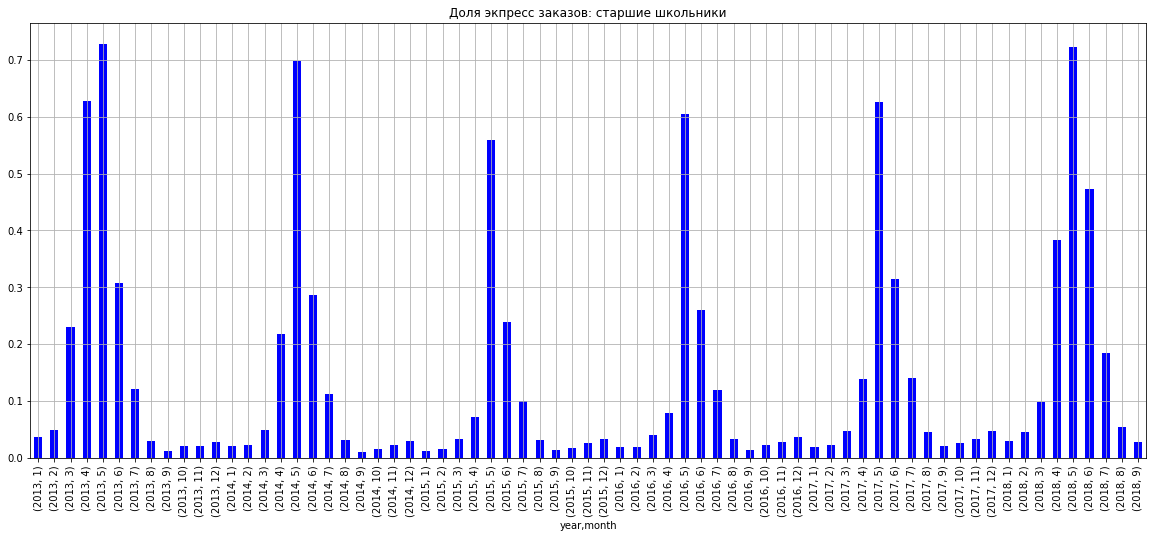

In [17]:
school = data[data['uvozr'].isin([35,40]) & data['class'].isin([11, 9])].groupby(['year','month'])
grp = school['target'].mean().plot(kind='bar', figsize = (20,8), colormap ='brg',grid=True, title = 'Доля экпресс заказов: старшие школьники')

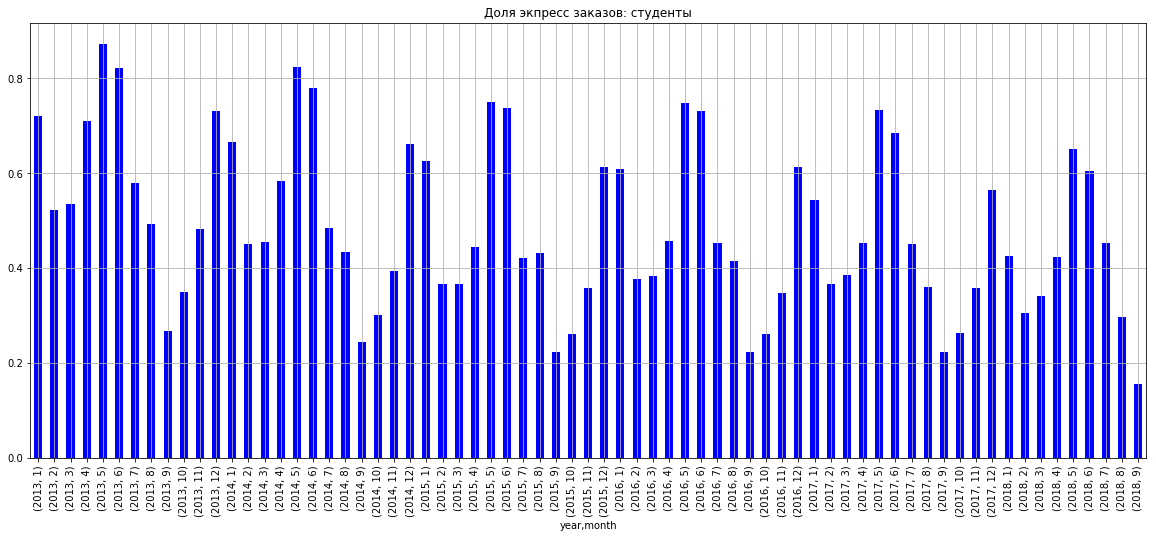

In [387]:
univer = data[data['uvozr'].isin([50,60])].groupby(['year','month'])
grp = univer['target'].mean().plot(kind='bar', figsize = (20,8), colormap ='brg',grid=True, title = 'Доля экпресс заказов: студенты')

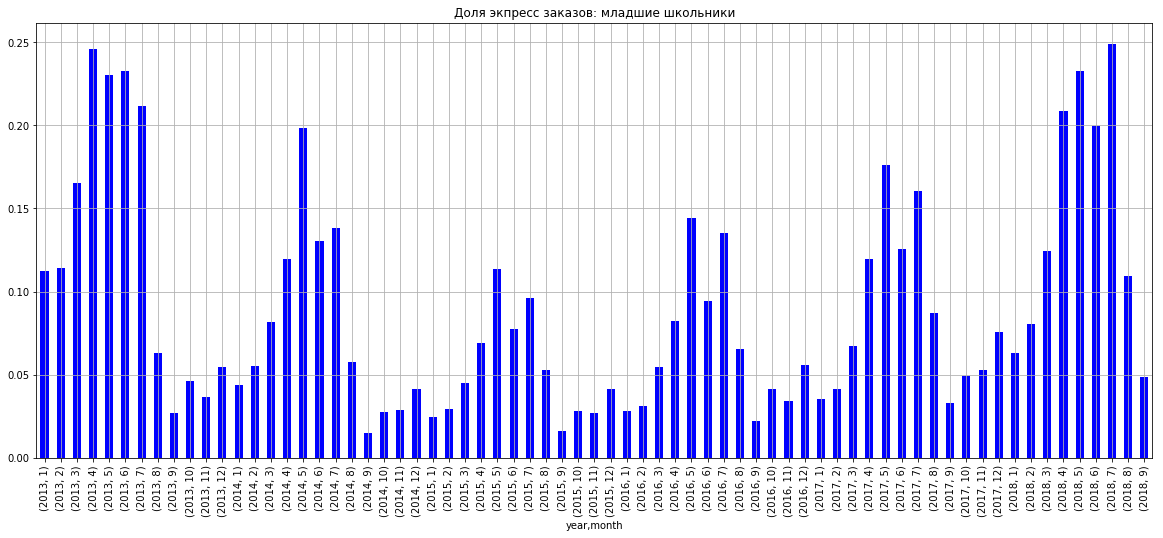

In [388]:
univer = data[data['uvozr'].isin([10,20,25,30])].groupby(['year','month'])
grp = univer['target'].mean().plot(kind='bar', figsize = (20,8), colormap ='brg',grid=True, title = 'Доля экпресс заказов: младшие школьники')

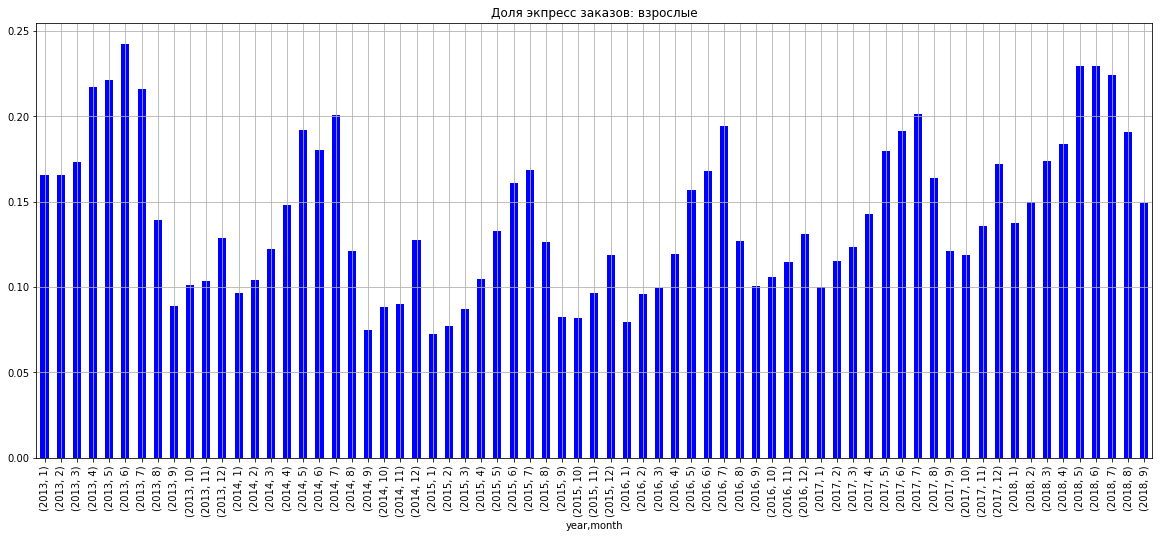

In [389]:
univer = data[data['uvozr'].isin([70,80,90])].groupby(['year','month'])
grp = univer['target'].mean().plot(kind='bar', figsize = (20,8), colormap ='brg',grid=True, title = 'Доля экпресс заказов: взрослые')

In [18]:
def randomforest(X,y,n_est, tpr_val, graph = True, max_features = 1):
    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,shuffle=False)
    
    fr = RandomForestClassifier(n_estimators=n_est, n_jobs=-1, max_features=max_features)
    
    cv = TimeSeriesSplit(n_splits = 8)
    
    cross_score = cross_val_score(fr, X_train, y_train, scoring ='roc_auc', cv=cv, n_jobs=-1)
    
    fr.fit(X_train, y_train)
    score = roc_auc_score(y_test, fr.predict_proba(X_test)[:,1])
    fpr, tpr, tresh = roc_curve(y_test, fr.predict_proba(X_test)[:,1] )
    
    if graph:
        fpr, tpr, tresh = roc_curve(y_test, fr.predict_proba(X_test)[:,1] )
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % score)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC AUC')
        plt.axis('square')
        plt.legend(loc="lower right")
        plt.grid()
        plt.show() 
    
        cm = confusion_matrix(y_test, (fr.predict_proba(X_test)[:,1] > tresh[tpr > tpr_val][0]).astype(int) )
        values_1 = (fr.predict_proba(X_test)[:,1] > tresh[tpr > tpr_val][0]).astype(int)
    
        plot_confusion_matrix(cm,[0,1])
    
    return cross_score, score, y_test, fr.predict_proba(X_test)[:,1], values_1, X_test

In [60]:
# Модели
# Лес без весны

In [131]:
tree_data_no_spr = tree_data[~tree_data['month'].isin((4,5,6))]
tree_data_no_spr = tree_data_no_spr[tree_data_no_spr['year'] != 2018]
tree_data_no_spr = tree_data_no_spr[~((tree_data_no_spr['year'] == 2017) & (tree_data_no_spr['month'] > 8))]
tree_data_no_spr = pd.get_dummies(tree_data_no_spr, columns=['month','aimi','prodolzh'])

In [132]:
tree_data_no_spr.head(1)

,city,mesto,stoim,wgender,obraz,opyt,uvozr,ulevel,target,class,...,prodolzh_-2,prodolzh_-1,prodolzh_0,prodolzh_1,prodolzh_2,prodolzh_3,prodolzh_4,prodolzh_5,prodolzh_6,prodolzh_11
0,2.0,-1,300,0,0,0,30,10,0,0,...,0,0,0,0,1,0,0,0,0,0


In [133]:
X_tree = tree_data_no_spr.drop(columns=['target','year'])
y_tree = tree_data_no_spr['target']

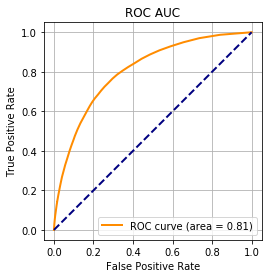

Confusion matrix, without normalization
[[222661  42556]
 [  5486   7889]]
[0.80887922 0.79550444 0.82931048 0.80258086 0.82445556 0.82324226
 0.83172831 0.80306486] 0.805656781350514


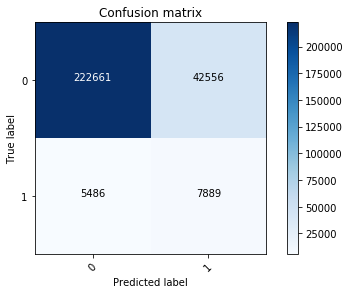

In [134]:
scores, score, true, pred = randomforest(X_tree, y_tree, tpr_val=0.6, n_est=250)
print(scores, score)

In [90]:
score, img = one_tree_gc(X_tree, y_tree)
print(score)
img

KeyboardInterrupt: 

In [ ]:
# Старшеклассники

In [19]:
tree_11 = tree_data[tree_data['uvozr'].isin([35,40])]
# tree_11 = tree_11[tree_11['year'] != 2018]
# tree_11 = tree_11[~((tree_11['year'] == 2017) & (tree_11['month'] > 8))]
tree_11 = tree_11[~((tree_11['year'] == 2013) & (tree_11['month'] < 7))]
tree_11 = pd.get_dummies(tree_11, columns=['month','aimi'])


X_tree = tree_11.drop(columns=['target','year'])
y_tree = tree_11['target']

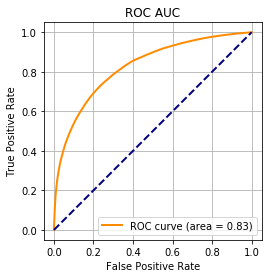

Confusion matrix, without normalization
[[217329  33178]
 [ 12224  18079]]
[0.72873797 0.81510377 0.92403609 0.85564589 0.90592864 0.83847306
 0.87235566 0.87335306] 0.825316428628911


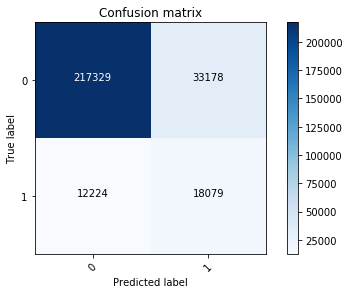

In [20]:
scores, score, true_11, pred_11, values_1, X_test = randomforest(X_tree, y_tree, 250, 0.6)
print(scores, score)

In [21]:
# print(true_11.count(), len(pred_11))

pred_analysis = pd.DataFrame(X_test)
pred_analysis['y_test'] = true_11
pred_analysis['y_pred'] = values_1
pred_analysis.reset_index(inplace=True, drop=True)

In [22]:
# pred_analysis['y_pred'].value_counts()
pred_analysis.columns

Index(['city', 'mesto', 'prodolzh', 'stoim', 'wgender', 'obraz', 'opyt',
       'uvozr', 'ulevel', 'class', 'retake', 'aim_ege_typ', 'basic_typ',
       'ege_typ', 'olimp_typ', 'lang_typ', 'word_ex_typ', 'music_typ',
       'logoped_typ', 'hour', 'weekday', 'day', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'aimi_-30', 'aimi_-20',
       'aimi_-10', 'aimi_0', 'aimi_10', 'aimi_20', 'aimi_30', 'aimi_40',
       'y_test', 'y_pred'],
      dtype='object')

In [23]:
pred_analysis['match?'] = np.where(pred_analysis['y_test'] != pred_analysis['y_pred'], 0, 1)
pred_analysis.shape

(280810, 45)

In [24]:
pred_analysis.columns

Index(['city', 'mesto', 'prodolzh', 'stoim', 'wgender', 'obraz', 'opyt',
       'uvozr', 'ulevel', 'class', 'retake', 'aim_ege_typ', 'basic_typ',
       'ege_typ', 'olimp_typ', 'lang_typ', 'word_ex_typ', 'music_typ',
       'logoped_typ', 'hour', 'weekday', 'day', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'aimi_-30', 'aimi_-20',
       'aimi_-10', 'aimi_0', 'aimi_10', 'aimi_20', 'aimi_30', 'aimi_40',
       'y_test', 'y_pred', 'match?'],
      dtype='object')

In [25]:
from itertools import groupby

def back_from_dummies(df):
    result_series = {}

    # Find dummy columns and build pairs (category, category_value)
    dummmy_tuples = [(col.split("_")[0],col) for col in df.columns if "aimi_" in col or "month_" in col]

    # Find non-dummy columns that do not have a _
    non_dummy_cols = [col for col in df.columns if "aimi_" not in col and "month_" not in col]

    # For each category column group use idxmax to find the value.
    for dummy, cols in groupby(dummmy_tuples, lambda item: item[0]):

        #Select columns for each category
        dummy_df = df[[col[1] for col in cols]]

        # Find max value among columns
        max_columns = dummy_df.idxmax(axis=1)

        # Remove category_ prefix
        result_series[dummy] = max_columns.apply(lambda item: item.split("_")[1])

    # Copy non-dummy columns over.
    for col in non_dummy_cols:
        result_series[col] = df[col]

    # Return dataframe of the resulting series
    return pd.DataFrame(result_series)

new_df_1 = back_from_dummies(pred_analysis)


In [26]:
new_df_1['month'].value_counts()

1     35243
10    34682
9     30190
11    28686
8     28076
2     26552
3     21114
12    19988
4     16483
7     13700
5     13232
6     12864
Name: month, dtype: int64

In [27]:
#new_df_1 = new_df_1[new_df_1['y_test'] == 1]
pred_analysis.columns


Index(['city', 'mesto', 'prodolzh', 'stoim', 'wgender', 'obraz', 'opyt',
       'uvozr', 'ulevel', 'class', 'retake', 'aim_ege_typ', 'basic_typ',
       'ege_typ', 'olimp_typ', 'lang_typ', 'word_ex_typ', 'music_typ',
       'logoped_typ', 'hour', 'weekday', 'day', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'aimi_-30', 'aimi_-20',
       'aimi_-10', 'aimi_0', 'aimi_10', 'aimi_20', 'aimi_30', 'aimi_40',
       'y_test', 'y_pred', 'match?'],
      dtype='object')

In [28]:
new_df_1.head(10)

,month,aimi,city,mesto,prodolzh,stoim,wgender,obraz,opyt,uvozr,...,lang_typ,word_ex_typ,music_typ,logoped_typ,hour,weekday,day,y_test,y_pred,match?
0,9,40,2.0,3,2,500,0,0,0,35,...,0,0,0,0,16,6,17,0,0,1
1,9,30,0.0,0,2,1000,0,20,0,35,...,0,0,0,0,16,6,17,0,0,1
2,9,40,0.0,1,1,2000,-2,20,0,40,...,1,0,0,0,16,6,17,0,0,1
3,9,30,2.0,1,2,500,0,0,0,35,...,0,0,0,0,16,6,17,0,0,1
4,9,30,0.0,1,0,2000,0,20,0,35,...,0,0,0,0,16,6,17,0,0,1
5,9,30,0.0,3,2,1000,0,0,0,35,...,0,0,0,0,16,6,17,1,1,1
6,9,40,2.0,-1,2,300,0,0,0,40,...,0,0,0,0,16,6,17,0,0,1
7,9,40,0.0,-1,1,1000,-2,0,0,40,...,0,0,0,0,16,6,17,0,0,1
8,9,40,2.0,3,1,900,-2,0,0,35,...,0,0,0,0,16,6,17,1,0,0
9,9,40,2.0,0,2,500,-2,0,0,40,...,0,0,0,0,16,6,17,0,0,1


In [29]:
aggregate = {
    'y_pred' : 'max',
    'match?' : {
        'count_all': 'count',
        'count_all_mistakes': lambda x: pd.Series.where(x, x == 0).count(),
        'count_all_fact_all_express': lambda x: pd.Series.where(x, new_df_1['y_test'] == 1).count(),
        'count_FP': lambda x: pd.Series.where(x, np.logical_and(new_df_1['y_test'] == 1, new_df_1['y_pred'] == 0)).count(),        
        'count_TP': lambda x: pd.Series.where(x, np.logical_and(new_df_1['y_test'] == 1, new_df_1['y_pred'] == 1)).sum()
    }
}

In [30]:
new_df_1['aimi'] = new_df_1['aimi'].astype('int')

In [31]:
new_df_1['aimi'] = np.where(new_df_1['aimi'] <= 0, "-30 - 0", new_df_1['aimi']).astype('str')
# new_df_1 = new_df_1[(new_df_1['word_ex_typ'] == 0) & (new_df_1['music_typ'] == 0)]
new_df_1 = new_df_1[new_df_1['obraz'] != 35]

In [32]:
new_df_1.columns

Index(['month', 'aimi', 'city', 'mesto', 'prodolzh', 'stoim', 'wgender',
       'obraz', 'opyt', 'uvozr', 'ulevel', 'class', 'retake', 'aim_ege_typ',
       'basic_typ', 'ege_typ', 'olimp_typ', 'lang_typ', 'word_ex_typ',
       'music_typ', 'logoped_typ', 'hour', 'weekday', 'day', 'y_test',
       'y_pred', 'match?'],
      dtype='object')

In [33]:
# all analysis
ready_export = new_df_1.groupby(['month', 'aimi', 'class', 'retake', 'aim_ege_typ']).agg(aggregate)
ready_export.to_csv('123_11.csv')

/usr/local/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [39]:
# retake analysis
ready_export = new_df_1.groupby(['month', 'aimi', 'retake', 'aim_ege_typ']).agg(aggregate)
ready_export.to_csv('123_8.csv')

/usr/local/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [40]:
new_df_1.columns

Index(['month', 'aimi', 'city', 'mesto', 'prodolzh', 'stoim', 'wgender',
       'obraz', 'opyt', 'uvozr', 'ulevel', 'class', 'retake', 'aim_ege_typ',
       'basic_typ', 'ege_typ', 'olimp_typ', 'lang_typ', 'word_ex_typ',
       'music_typ', 'logoped_typ', 'hour', 'weekday', 'day', 'y_test',
       'y_pred', 'match?'],
      dtype='object')

In [41]:
print("Accuracy is ", accuracy_score(true_11,values_1)*100)

Accuracy is  83.6044688619252


In [42]:
pred_analysis.head(5)

,city,mesto,prodolzh,stoim,wgender,obraz,opyt,uvozr,ulevel,class,...,aimi_-20,aimi_-10,aimi_0,aimi_10,aimi_20,aimi_30,aimi_40,y_test,y_pred,match?
0,0.0,0,1,1500,0,0,0,40,40,11,...,0,0,0,0,0,0,1,0,0,1
1,2.0,0,2,400,0,0,0,35,30,8,...,0,0,0,0,0,1,0,0,0,1
2,2.0,0,2,400,0,20,0,40,30,10,...,0,0,0,0,0,1,0,0,1,0
3,2.0,0,1,750,0,0,0,35,30,9,...,0,0,0,0,0,1,0,0,1,0
4,0.0,3,2,450,0,0,0,35,-30,8,...,0,0,0,0,0,0,1,0,0,1


In [43]:
# студенты

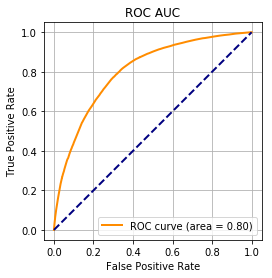

Confusion matrix, without normalization
[[20668  4304]
 [ 7502 11186]]
[0.83061474 0.83183499 0.82901136 0.83266601 0.82397865 0.80631453
 0.77178911 0.81897818] 0.8045702464585679


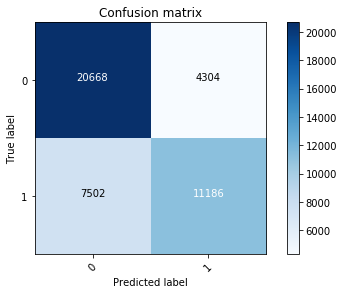

In [183]:
tree_st = tree_data[tree_data['uvozr'].isin([50,60])]
# tree_st = tree_st[tree_st['year'] != 2018]
# tree_st = tree_st[~((tree_st['year'] == 2018) & (tree_st['month'] > 7))]
tree_st = tree_st[~((tree_st['year'] == 2013) & (tree_st['month'] < 7))]
tree_st = pd.get_dummies(tree_st, columns=['month','aimi'])


X_tree = tree_st.drop(columns=['target','year'])
y_tree = tree_st['target']

scores, score, true_st, pred_st, values_st, X_test_st = randomforest(X_tree, y_tree, tpr_val=0.6, n_est=250)
print(scores, score)

,city,mesto,prodolzh,stoim,wgender,obraz,opyt,aimi,uvozr,ulevel,...,olimp_typ,lang_typ,word_ex_typ,music_typ,logoped_typ,month,hour,weekday,day,year
3,2.0,1,0,800,0,20,50,40,60,10,...,0,0,0,0,0,1,3,1,1,2013
13,2.0,0,0,1000,0,0,0,30,60,20,...,0,0,0,0,0,1,12,1,1,2013
19,2.0,-1,2,400,0,0,0,-20,50,20,...,0,0,0,0,0,1,13,1,1,2013
20,2.0,0,1,600,0,0,0,40,60,10,...,0,0,0,0,0,1,13,1,1,2013
21,0.0,0,1,1800,0,20,0,30,60,10,...,0,1,0,0,0,1,13,1,1,2013
22,2.0,1,2,400,-2,15,0,30,60,30,...,0,0,0,0,0,1,13,1,1,2013
24,2.0,1,2,400,0,20,50,30,60,30,...,0,0,0,0,0,1,14,1,1,2013
26,2.0,1,2,400,-2,15,0,40,60,30,...,0,0,0,0,0,1,14,1,1,2013
33,0.0,0,1,1500,0,0,55,40,60,30,...,0,0,0,0,0,1,15,1,1,2013
41,0.0,-1,1,1500,0,20,0,40,60,20,...,0,0,0,0,0,1,16,1,1,2013


In [185]:
pred_analysis_st = pd.DataFrame(X_test_st)
pred_analysis_st['y_test'] = true_st
pred_analysis_st['y_pred'] = values_st
pred_analysis_st.reset_index(inplace=True, drop=True)

pred_analysis_st['match?'] = np.where(pred_analysis_st['y_test'] != pred_analysis_st['y_pred'], 0, 1)
pred_analysis_st.shape

new_df_st = back_from_dummies(pred_analysis_st)

aggregate = {
    'y_pred' : 'max',
    'match?' : {
        'count_all': 'count',
        'count_all_mistakes': lambda x: pd.Series.where(x, x == 0).count(),
        'count_all_fact_all_express': lambda x: pd.Series.where(x, new_df_st['y_test'] == 1).count(),
        'count_FP': lambda x: pd.Series.where(x, np.logical_and(new_df_st['y_test'] == 1, new_df_st['y_pred'] == 0)).count(),        
        'count_TP': lambda x: pd.Series.where(x, np.logical_and(new_df_st['y_test'] == 1, new_df_st['y_pred'] == 1)).sum()
    }
}

new_df_st['aimi'] = new_df_st['aimi'].astype('int')
new_df_st['aimi'] = np.where(new_df_st['aimi'] <= 0, "-30 - 0", new_df_st['aimi']).astype('str')


In [188]:
X_test_st['month']

KeyError: 'month'

In [182]:
new_df_st['aimi'].value_counts()

40     18788
-30     9101
30      8214
0       4961
-10     2315
-20      257
20        24
Name: aimi, dtype: int64

In [125]:
# all analysis
ready_export_st = new_df_st.groupby(['month', 'aimi', 'retake', 'ulevel', 'aim_ege_typ', 'lang_typ']).agg(aggregate)
ready_export_st.to_csv('123_st.csv')

/usr/local/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [97]:
# школозавры

In [92]:
new_df_st['city'].value_counts()

2.0    40810
0.0    36016
1.0    10493
Name: city, dtype: int64

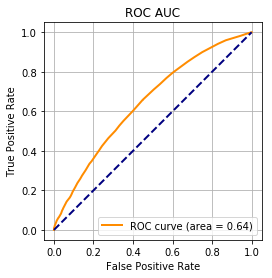

Confusion matrix, without normalization
[[28857 17226]
 [ 2466  3348]]
[0.7521794  0.6525609  0.69616001 0.64710807 0.66679358 0.69169552
 0.65516963 0.6628317 ] 0.6446556164894168


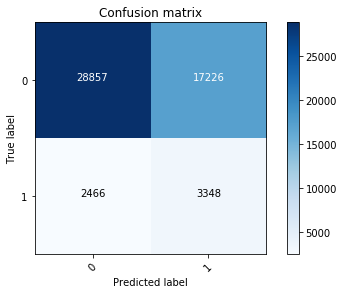

In [36]:
tree_7 = tree_data[tree_data['uvozr'].isin([10, 1500])]   #,
# tree_7 = tree_7[tree_7['year'] != 2018]
# tree_7 = tree_7[~((tree_7['year'] == 2017) & (tree_7['month'] > 8))]
tree_7 = tree_7[~((tree_7['year'] == 2013) & (tree_7['month'] < 7))]
tree_7 = pd.get_dummies(tree_7, columns=['month','aimi'])

X_tree = tree_7.drop(columns=['target','year'])
y_tree = tree_7['target']

scores, score, true_7, pred_7, values_7, X_test_7 = randomforest(X_tree, y_tree, 250,0.6)
print(scores, score)

In [37]:
pred_analysis_7 = pd.DataFrame(X_test_7)
pred_analysis_7['y_test'] = true_7
pred_analysis_7['y_pred'] = values_7
pred_analysis_7.reset_index(inplace=True, drop=True)

pred_analysis_7['match?'] = np.where(pred_analysis_7['y_test'] != pred_analysis_7['y_pred'], 0, 1)
pred_analysis_7.shape

new_df_7 = back_from_dummies(pred_analysis_7)

aggregate = {
    'y_pred' : 'max',
    'match?' : {
        'count_all': 'count',
        'count_all_mistakes': lambda x: pd.Series.where(x, x == 0).count(),
        'count_all_fact_all_express': lambda x: pd.Series.where(x, new_df_7['y_test'] == 1).count(),
        'count_FP': lambda x: pd.Series.where(x, np.logical_and(new_df_7['y_test'] == 1, new_df_7['y_pred'] == 0)).count(),        
        'count_TP': lambda x: pd.Series.where(x, np.logical_and(new_df_7['y_test'] == 1, new_df_7['y_pred'] == 1)).sum()
    }
}

new_df_7['aimi'] = new_df_7['aimi'].astype('int')
new_df_7['aimi'] = np.where(new_df_7['aimi'] <= 0, "-30 - 0", new_df_7['aimi']).astype('str')



In [179]:
new_df_7['month'].value_counts()

1     10789
2      9286
3      9121
8      8329
4      7318
5      7187
9      6905
6      6698
7      6443
12     5581
10     4886
11     4242
Name: month, dtype: int64

In [38]:
# all analysis
ready_export_7 = new_df_7.groupby(['month', 'aimi', 'ulevel', 'basic_typ', 'music_typ','lang_typ', 'logoped_typ']).agg(aggregate)
ready_export_7.to_csv('123_7_9.csv')

/usr/local/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [421]:
# взрослые

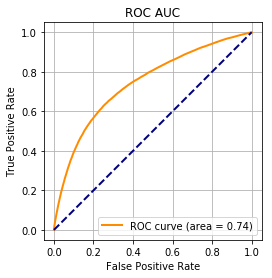

Confusion matrix, without normalization
[[67899 19598]
 [ 7816 11586]]
[0.76348164 0.76965565 0.77808131 0.77578896 0.77863064 0.76900961
 0.75930446 0.75845925] 0.7420474729351672


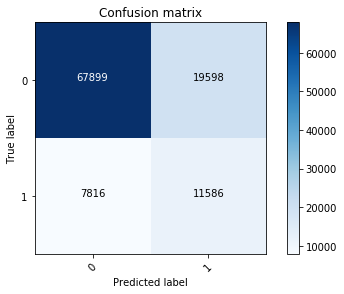

In [69]:
tree_ad = tree_data[tree_data['uvozr'].isin([70,80,90])]
# tree_ad = tree_ad[tree_ad['year'] != 2018]
# tree_ad = tree_ad[~((tree_ad['year'] == 2017) & (tree_ad['month'] > 8))]
tree_ad = tree_ad[~((tree_ad['year'] == 2013) & (tree_ad['month'] < 7))]
tree_ad = pd.get_dummies(tree_ad, columns=['month','aimi'])

X_tree = tree_ad.drop(columns=['target','year'])
y_tree = tree_ad['target']

scores, score, true_ad, pred_ad, values_ad, X_test_ad = randomforest(X_tree, y_tree, 250,0.6)
print(scores, score)

In [70]:
pred_analysis_ad = pd.DataFrame(X_test_ad)
pred_analysis_ad['y_test'] = true_ad
pred_analysis_ad['y_pred'] = values_ad
pred_analysis_ad.reset_index(inplace=True, drop=True)

pred_analysis_ad['match?'] = np.where(pred_analysis_ad['y_test'] != pred_analysis_ad['y_pred'], 0, 1)
pred_analysis_ad.shape

new_df_ad = back_from_dummies(pred_analysis_ad)

aggregate = {
    'y_pred' : 'max',
    'match?' : {
        'count_all': 'count',
        'count_all_mistakes': lambda x: pd.Series.where(x, x == 0).count(),
        'count_all_fact_all_express': lambda x: pd.Series.where(x, new_df_ad['y_test'] == 1).count(),
        'count_FP': lambda x: pd.Series.where(x, np.logical_and(new_df_ad['y_test'] == 1, new_df_ad['y_pred'] == 0)).count(),
        'count_TP': lambda x: pd.Series.where(x, np.logical_and(new_df_ad['y_test'] == 1, new_df_ad['y_pred'] == 1)).sum()
    }
}

new_df_ad['aimi'] = new_df_ad['aimi'].astype('int')
# new_df_ad['aimi'] = np.where(new_df_ad['aimi'] <= 0, "-30 - 0", new_df_ad['aimi']).astype('str')

In [71]:
# new_df_ad = new_df_ad[(new_df_ad['lang_typ'] == 0) & (new_df_ad['music_typ'] == 0)]
new_df_ad = new_df_ad[new_df_ad['obraz'] != 35]

In [180]:
new_df_ad['month'].value_counts()

1     11303
8     10487
3     10408
2      9993
7      9869
5      9038
4      8962
6      8712
11     7994
12     6304
9      1735
10      617
Name: month, dtype: int64

In [73]:
# all analysis 'ulevel', 'obraz',
ready_export_ad = new_df_ad.groupby(['month', 'aimi', 'aim_ege_typ', 'basic_typ', 'lang_typ' , 'word_ex_typ', 'music_typ']).agg(aggregate)
ready_export_ad.to_csv('123_ad.csv')

/usr/local/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [99]:
tree_st = tree_data[tree_data['uvozr'].isin([10,20,25,30])]
tree_st = tree_st[tree_st['year'] != 2018]
tree_st = tree_st[~((tree_st['year'] == 2017) & (tree_st['month'] > 8))]
rocs_st = []
for i in tqdm(range(12)):
    tree_st_i = tree_st[tree_st['month'].isin([i+1])]
    X_tree = tree_st_i.drop(columns=['target','year'])
    y_tree = tree_st_i['target']

    _, score, _, _ = randomforest(X_tree, y_tree, 250,0.6, graph=False)
    rocs_st.append(score)

100%|██████████| 12/12 [01:37<00:00,  8.16s/it]


Text(0,0.5,'Roc_auc')

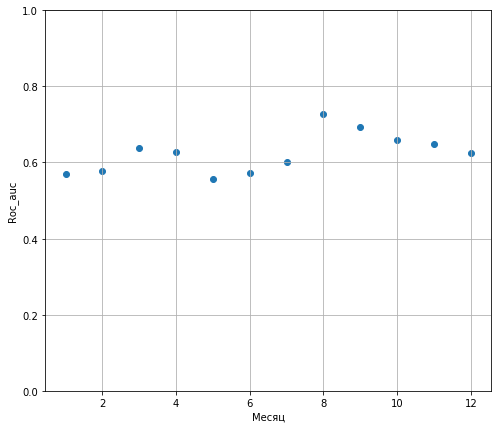

In [100]:
plt.figure(figsize=(8,7))
plt.scatter(np.array(range(12)) + 1,rocs_st)
plt.ylim(0,1)
plt.grid()
plt.xlabel('Месяц')
plt.ylabel('Roc_auc')

In [101]:
# студенты month

In [102]:
tree_st = tree_data[tree_data['uvozr'].isin([50,60])]
tree_st = tree_st[tree_st['year'] != 2018]
tree_st = tree_st[~((tree_st['year'] == 2017) & (tree_st['month'] > 8))]
tree_st = tree_st[~((tree_st['year'] == 2013) & (tree_st['month'] < 7))]
rocs_st = []
for i in tqdm(range(12)):
    tree_st_i = tree_st[tree_st['month'].isin([i+1])]
    X_tree = tree_st_i.drop(columns=['target','year'])
    y_tree = tree_st_i['target']

    _, score,_,_ = randomforest(X_tree, y_tree, 250,0.6, graph=False)
    rocs_st.append(score)

100%|██████████| 12/12 [00:41<00:00,  3.42s/it]


Text(0,0.5,'Roc_auc')

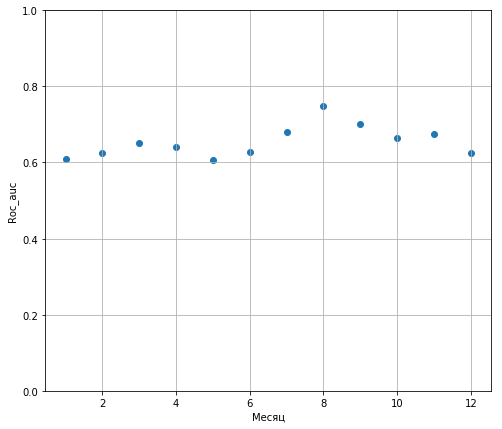

In [103]:
plt.figure(figsize=(8,7))
plt.scatter(np.array(range(12)) + 1,rocs_st)
plt.ylim(0,1)
plt.grid()
plt.xlabel('Месяц')
plt.ylabel('Roc_auc')

In [104]:
# старшие школьники

In [109]:
tree_st = tree_data[tree_data['uvozr'].isin([35,40])]
tree_st = tree_st[tree_st['year'] != 2018]
tree_st = tree_st[~((tree_st['year'] == 2017) & (tree_st['month'] > 8))]
tree_st = tree_st[~((tree_st['year'] == 2013) & (tree_st['month'] < 7))]
rocs_st = []
for i in tqdm(range(12)):
    tree_st_i = tree_st[tree_st['month'].isin([i+1])]
    X_tree = tree_st_i.drop(columns=['target','year'])
    y_tree = tree_st_i['target']

    _, score,_,_ = randomforest(X_tree, y_tree, 250,0.6, graph=False)
    rocs_st.append(score)



  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:09<01:41,  9.24s/it]

 17%|█▋        | 2/12 [00:16<01:24,  8.45s/it]

 25%|██▌       | 3/12 [00:24<01:13,  8.13s/it]

 33%|███▎      | 4/12 [00:30<01:00,  7.53s/it]

 42%|████▏     | 5/12 [00:34<00:48,  6.95s/it]

 50%|█████     | 6/12 [00:39<00:39,  6.57s/it]

 58%|█████▊    | 7/12 [00:44<00:31,  6.33s/it]

 67%|██████▋   | 8/12 [00:52<00:26,  6.50s/it]

 75%|███████▌  | 9/12 [01:04<00:21,  7.21s/it]

 83%|████████▎ | 10/12 [01:13<00:14,  7.38s/it]

 92%|█████████▏| 11/12 [01:20<00:07,  7.35s/it]

100%|██████████| 12/12 [01:25<00:00,  7.16s/it]



Text(0,0.5,'Roc_auc')

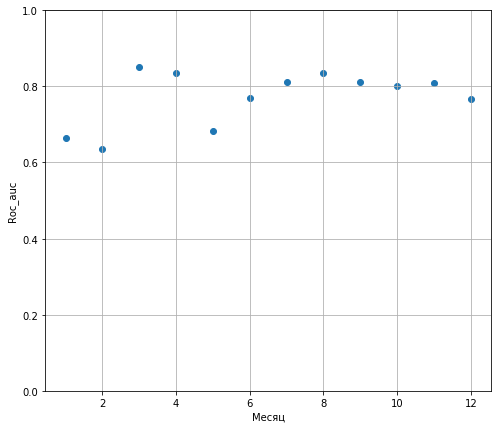

In [110]:
plt.figure(figsize=(8,7))
plt.scatter(np.array(range(12)) + 1,rocs_st)
plt.ylim(0,1)
plt.grid()
plt.xlabel('Месяц')
plt.ylabel('Roc_auc')

array([0.024, 0.004, 0.   , ..., 0.004, 0.004, 0.   ])